In [1]:
import pandas as pd
import geopandas as gpd
from requests import Request
from shapely.geometry import box

# Obtengo los datos de establecimientos productivos
estab = pd.read_csv('https://cdn.produccion.gob.ar/cdn-cep/establecimientos-productivos/distribucion_establecimientos_productivos_sexo.csv')

# Obtengo datos del nomenclador de AFIP
clae = pd.read_csv('https://cdn.produccion.gob.ar/cdn-cep/clae_agg.csv')

# Uno los datos de establecimientos con el nomenclador
estab = estab.merge(clae[['clae6', 'letra_desc']], left_on='clae6', right_on='clae6')

# Filtro los del sector agropecuario
estab_agro = estab[estab['letra_desc'] == ' AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y PESCA']

# Transformo los datos de establecimientos a un GeoDataFrame
estab_agro_gpd = gpd.GeoDataFrame(estab_agro, geometry=gpd.points_from_xy(estab_agro.lon, estab_agro.lat), crs='EPSG:4326')

# Obtengo los datos de los nodos de REFEFO
idecom_url = 'https://www.idecom.gob.ar/geoserver/ows'
params = {
    'service': 'wfs',
    'version': '1.3.0',
    'request': 'GetFeature',
    'typeName': 'idera:a010504-NODOS-FO',
    'outputFormat': 'json'
}

refefo_nodos_url = Request('GET', idecom_url, params=params).prepare().url

refefo_nodos = gpd.read_file(refefo_nodos_url)

# Obtengo los datos de la geometría de las provincias
ign_url = 'https://wms.ign.gob.ar/geoserver/ows'
params = {
    'service': 'wfs',
    'version': '1.1.0',
    'request': 'GetFeature',
    'typeName': 'ign:provincia',
    'outputFormat': 'json'
}

prov_url = Request('GET', ign_url, params=params).prepare().url
prov = gpd.read_file(prov_url)

# Recorto las provincias a la parte continental de Argentina
bbox = (-76.36532,
        -56.75009,
        -51.20850,
        -20.91625)
bbox = gpd.GeoSeries([box(*bbox)], crs=prov.crs)

prov_clipped = gpd.clip(prov, bbox)



In [4]:
estab_agro_refefo_gpd = estab_agro_gpd.to_crs(crs=3857).sjoin_nearest(refefo_nodos.to_crs(3857), how='left', distance_col='distance')

In [5]:
color1 = [160.0/255.0, 160.0/255.0, 160.0/255.0, 1.0]
color2 = [0.0, 200.0/255.0, 200.0/255.0, 1.0]
color3 = [0.0, 255.0/255.0, 255.0/255.0, 1.0]
color4 = [94.0/255.0, 144.0/255.0, 227.0/255.0, 1.0]
color5 = [111.0/255.0, 109.0/255.0, 163.0/255.0, 1.0]

colors = [color1, color2, color3, color4, color5]

# Style
def crossval_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='y', linestyle='-', alpha=0.4)

# Size
fig_size_bar = (7, 4)
size_labels = 10
size_tick_labels = 8

fuente_bar_pos_x = 0.0
fuente_bar_pos_y = -0.4

fuente_map_pos_x = -74.0
fuente_map_pos_y = -59.0

fontname = 'Avenir'
font_weight = 'ultralight'


/var/folders/_7/80b7r22d48j6n3m0r4vsgvdm0000gn/T/ipykernel_46263/1757400123.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontname=fontname, fontsize=size_tick_labels, weight=font_weight)
/var/folders/_7/80b7r22d48j6n3m0r4vsgvdm0000gn/T/ipykernel_46263/1757400123.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontname=fontname, fontsize=size_tick_labels, weight=font_weight)


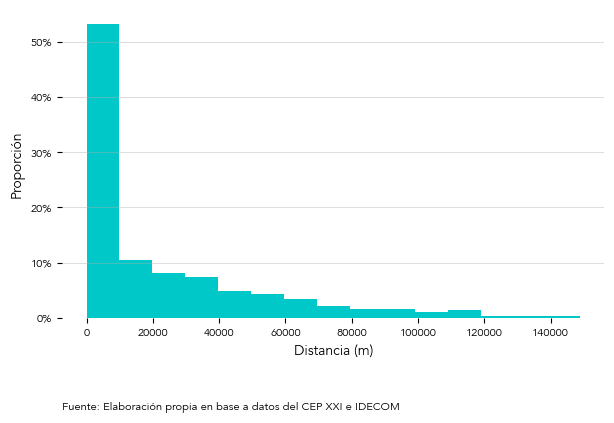

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

counts, bins = np.histogram(estab_agro_refefo_gpd[estab_agro_refefo_gpd['distance'] < 150000]['distance'], bins=15)

density = counts / np.sum(counts)

fig, ax = plt.subplots(figsize=(7, 4))

# ax = estab_agro_refefo_gpd[estab_agro_refefo_gpd['distance'] < 150000]['distance'].hist(density=True, bins=15)
ax.hist(bins[:-1], bins, weights=density, color=colors[1])

# Format the yticklabels to show actual proportions
# ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=0.0001))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

# Set the font family and size of the x-axis label
ax.set_xlabel('Distancia (m)', fontname=fontname, fontsize=size_labels, weight=font_weight)

# Set the font family and size of the y-axis label
ax.set_ylabel('Proporción', fontname=fontname, fontsize=size_labels, weight=font_weight)

# Set the font family and size of the x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), fontname=fontname, fontsize=size_tick_labels, weight=font_weight)

# Set the font family and size of the y-axis tick labels
ax.set_yticklabels(ax.get_yticklabels(), fontname=fontname, fontsize=size_tick_labels, weight=font_weight)

crossval_style(ax)

ax.text(x = fuente_bar_pos_x, y = -0.3, s = f"Fuente: Elaboración propia en base a datos del CEP XXI e IDECOM", transform=ax.transAxes, fontname=fontname, fontsize=size_tick_labels, weight=font_weight)

plt.show()


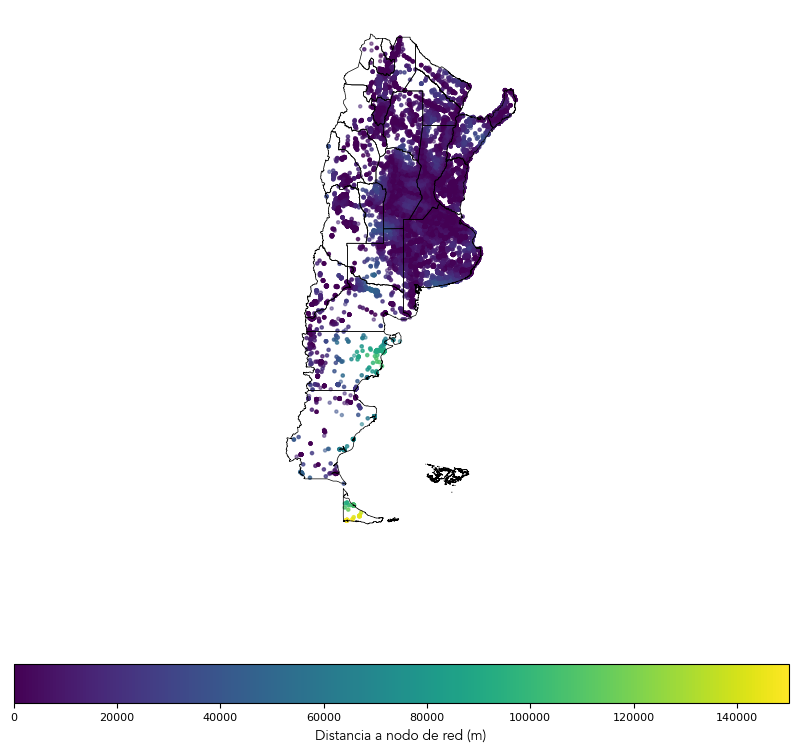

In [7]:
from matplotlib import cm
import matplotlib as mpl

# cmap = cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=150000)

fig, ax = plt.subplots(figsize=(10, 10))

prov_clipped.boundary.plot(ax=ax, color='black', linewidth=0.5)

estab_agro_refefo_gpd.to_crs('EPSG:4326').plot(ax=ax, c=estab_agro_refefo_gpd['distance'], markersize=5, alpha=0.5, legend=True)


ax.set_axis_off()

cbar = fig.colorbar(cm.ScalarMappable(norm), ax=ax, orientation='horizontal')
cbar.set_label('Distancia a nodo de red (m)', fontname=fontname, fontsize=size_labels, weight=font_weight)
cbar.ax.tick_params(labelsize=size_tick_labels)
plt.show()

In [8]:
estab_agro_refefo_gpd.head()

,cuit,sucursal,anio,lat,lon,clae6,in_departamentos,provincia_id,quintil,empleo,...,CUICOM,NivAcc,Localidad,Departamen,Provincia,OPERAT,OBSERV,Longitud,Latitud,distance
2,41X8684801PW69,1,2021,-31.831,-68.538,13019,70070,70,0,a. 1-9,...,116000998,,Tupeli,25 de Mayo,San Juan,Conectado,ReFeFO,-68.355148,-31.835497,20363.518228
6,8ZXA578022006P,1,2021,-35.707,-61.852,14113,6609,6,0,a. 1-9,...,116000747,,Pehuajo,Pehuajo,Buenos Aires,Conectado,ReFeFO,-61.886181,-35.808664,14455.869113
7,55X57A24220Z03,1,2021,-27.467,-58.801,14113,18021,18,0,a. 1-9,...,116000280,,Corrientes,Capital,Corrientes,Conectado,ReFeFO,-58.853519,-27.473892,5910.026706
8,62XA5Z5532016P,1,2021,-36.805,-63.338,14113,6007,6,0,a. 1-9,...,116000851,,Salliquelo,Salliqueló,Buenos Aires,Conectado,ReFeFO,-62.960400,-36.751767,42680.380667
11,02X7181Z420J70,1,2021,-33.812,-59.501,14610,6070,6,0,a. 1-9,...,116000103,,Baradero,Baradero,Buenos Aires,Conectado,ReFeFO,-59.509570,-33.810287,981.225711


In [10]:
estab_agro_refefo_gpd['distance'].describe()

count    139032.000000
mean      25544.488222
std       43024.509877
min          10.732621
25%        2012.328661
50%        8579.902917
75%       35895.504459
max      607665.364021
Name: distance, dtype: float64